## Stock Price Prediction using LSTM+TCN with Feature Engineering & Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Conv1D, GlobalAveragePooling1D, Input
from keras.optimizers import Adam
from tcn import TCN
import yfinance as yf
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.base import RegressorMixin, BaseEstimator
from keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


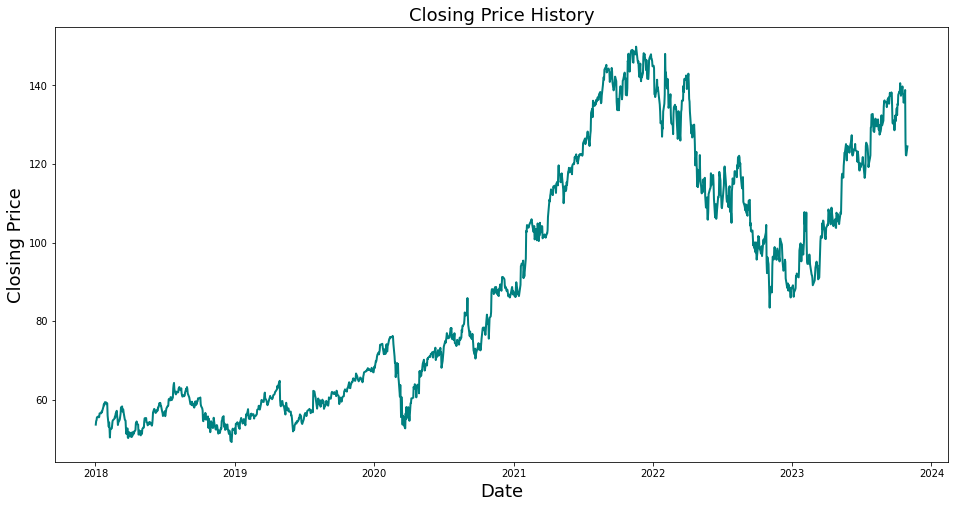

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='teal')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [7]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [8]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [9]:
# Reshape input to be [samples, time steps, features]
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

X_train_lstm shape:  (1166, 1, 7)
X_test_lstm shape:  (292, 1, 7)


In [11]:
# Create a Estimator class for LSTM model
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the LSTM model
lstm_model = LSTMEstimator()
lstm_model.fit(X_train_lstm, y_train)

LSTMEstimator()

In [12]:
# TCN Model
def create_tcn():
    model = Sequential()
    
    # TCN layers
    model.add(TCN(input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Reshape X_train
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

tcn_model = create_tcn()
tcn_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=0)

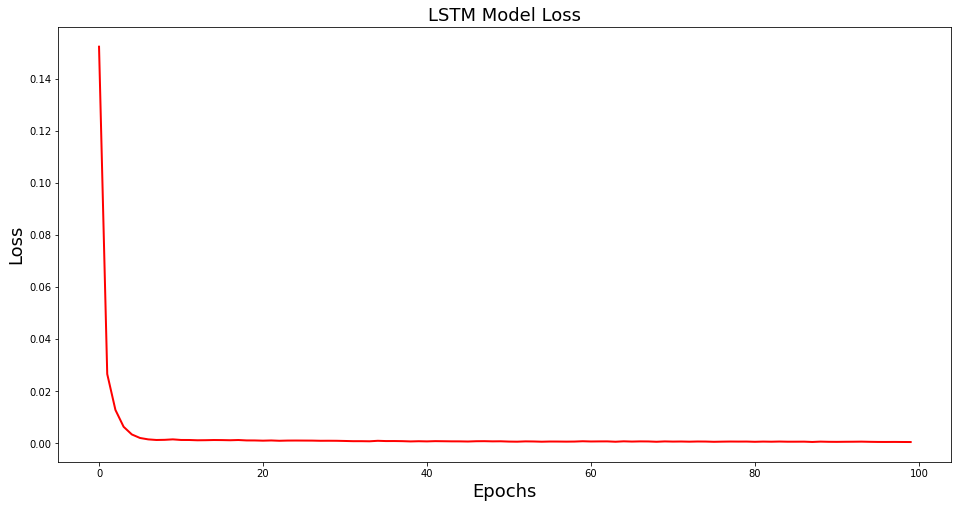

In [13]:
# Plot the training and validation loss for the LSTM model
plt.figure(figsize=(16,8))
plt.plot(lstm_model.model.history.history['loss'], linewidth=2, color='red')
plt.title('LSTM Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

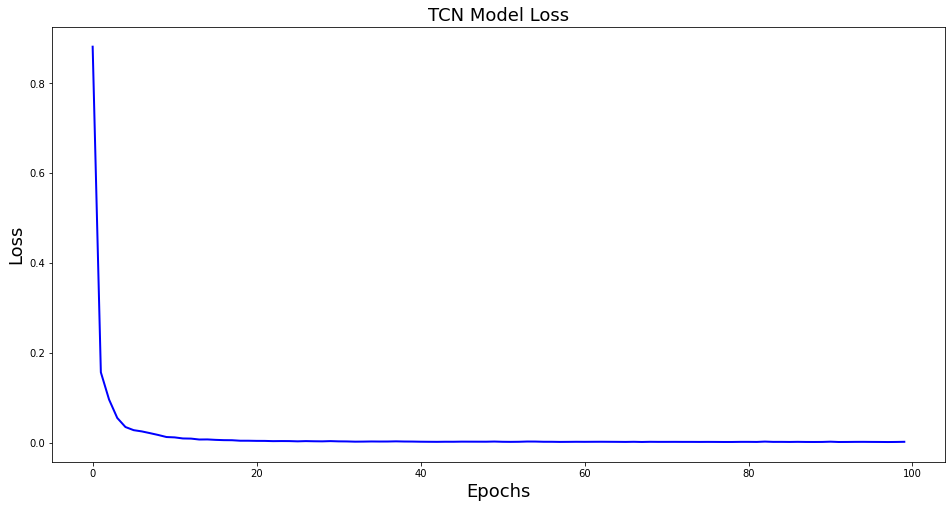

In [14]:
# Plot the training and validation loss for the TCN model
plt.figure(figsize=(16,8))
plt.plot(tcn_model.history.history['loss'], linewidth=2, color='blue')
plt.title('TCN Model Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [15]:
# Make predictions
lstm_pred = lstm_model.predict(X_test_lstm)
tcn_pred = tcn_model.predict(X_test)

# Invert predictions
lstm_pred_inv = target_scaler.inverse_transform(lstm_pred.reshape(-1,1))
tcn_pred_inv = target_scaler.inverse_transform(tcn_pred.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

10/10 [==============================] - 0s 4ms/step


In [16]:
# Create a stacked model
stacked_pred = np.column_stack((lstm_pred, tcn_pred))

# Train final regressor based on stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

# Make predictions
final_pred = final_regressor.predict(stacked_pred)

# Invert predictions
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1,1))

In [17]:
# Calculate the Evaluation Metrics for LSTM model
lstm_mse = mean_squared_error(y_test_inv, lstm_pred_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_inv, lstm_pred_inv)
lstm_r2 = r2_score(y_test_inv, lstm_pred_inv)

print("LSTM Model Evaluation Metrics")
print("------------------------------")
print("MSE: {:.4f}".format(lstm_mse))
print("RMSE: {:.4f}".format(lstm_rmse))
print("MAE: {:.4f}".format(lstm_mae))
print("R2: {:.4f}".format(lstm_r2))

LSTM Model Evaluation Metrics
------------------------------
MSE: 0.8132
RMSE: 0.9018
MAE: 0.7238
R2: 0.9969


In [18]:
# Calculate the Evaluation Metrics for TCN model
tcn_mse = mean_squared_error(y_test_inv, tcn_pred_inv)
tcn_rmse = np.sqrt(tcn_mse)
tcn_mae = mean_absolute_error(y_test_inv, tcn_pred_inv)
tcn_r2 = r2_score(y_test_inv, tcn_pred_inv)

print("TCN Model Evaluation Metrics")
print("----------------------------")
print("MSE: {:.4f}".format(tcn_mse))
print("RMSE: {:.4f}".format(tcn_rmse))
print("MAE: {:.4f}".format(tcn_mae))
print("R2: {:.4f}".format(tcn_r2))

TCN Model Evaluation Metrics
----------------------------
MSE: 1.4684
RMSE: 1.2118
MAE: 0.9111
R2: 0.9944


In [19]:
# Calculate the Evaluation metrics for stacked model
final_mse = mean_squared_error(y_test_inv, final_pred_inv)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test_inv, final_pred_inv)
final_r2 = r2_score(y_test_inv, final_pred_inv)

print("LSTM-TCN Stacked Model Evaluation Metrics")
print("--------------------------------")
print("MSE: {:.4f}".format(final_mse))
print("RMSE: {:.4f}".format(final_rmse))
print("MAE: {:.4f}".format(final_mae))
print("R2: {:.4f}".format(final_r2))

LSTM-TCN Stacked Model Evaluation Metrics
--------------------------------
MSE: 0.7095
RMSE: 0.8423
MAE: 0.6831
R2: 0.9973


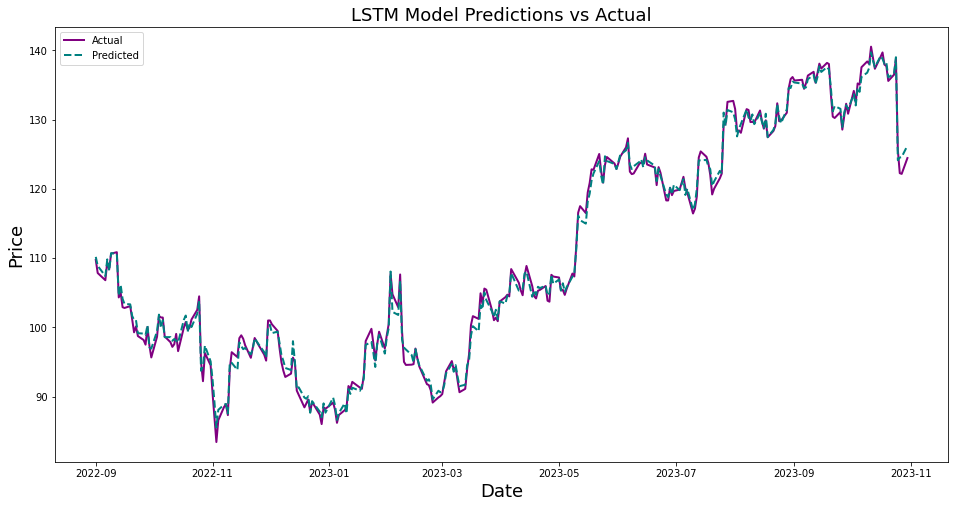

In [20]:
# Plot the actual vs predicted prices for LSTM model
plt.figure(figsize=(16,8))
plt.title('LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], lstm_pred_inv, linewidth=2, color='teal', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.show()

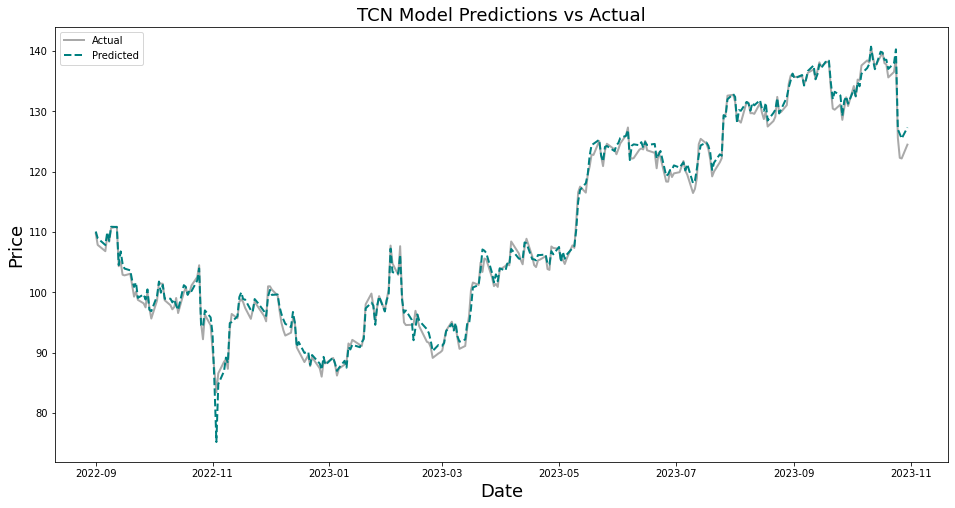

In [21]:
# Plot the actual vs predicted prices for TCN model
plt.figure(figsize=(16,8))
plt.title('TCN Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkgrey', label='Actual')
plt.plot(df1.index[-len(y_test):], tcn_pred_inv, linewidth=2, color='teal', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.show()

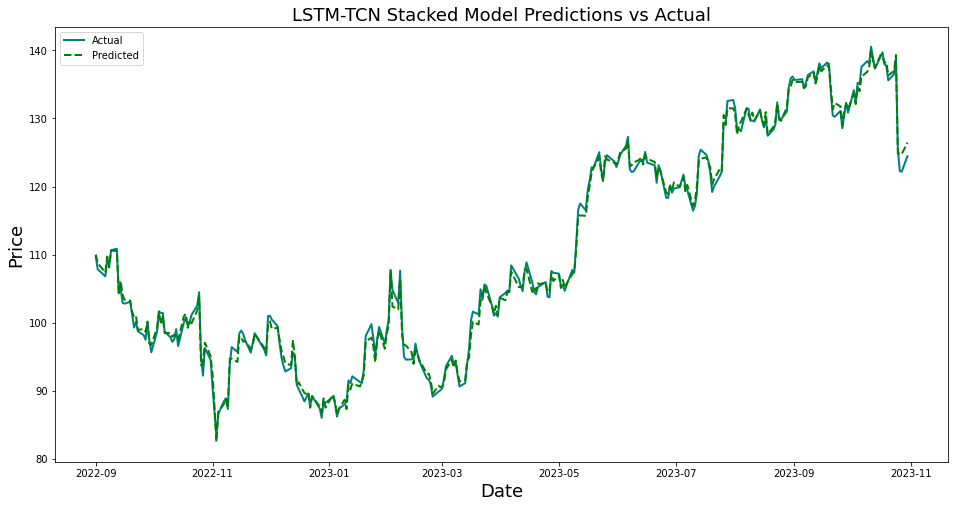

In [22]:
# Plot the actual vs predicted prices for LSTM model
plt.figure(figsize=(16,8))
plt.title('LSTM-TCN Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='teal', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='green', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [23]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'LSTM': lstm_pred_inv.flatten(), 'TCN': tcn_pred_inv.flatten(), 'Stacked': final_pred_inv.flatten()})
df_pred

,Date,Actual,LSTM,TCN,Stacked
0,2022-09-01,109.739998,110.182060,110.070908,110.006027
1,2022-09-02,107.849998,108.890198,108.946297,108.754745
2,2022-09-06,106.809998,107.404564,107.835487,107.365662
3,2022-09-07,109.449997,109.817764,109.962326,109.710159
4,2022-09-08,108.379997,108.181862,108.521576,108.121101
...,...,...,...,...,...
287,2023-10-24,138.809998,139.028488,140.252579,139.331512
288,2023-10-25,125.610001,124.148064,127.012329,124.840378
289,2023-10-26,122.279999,124.531593,126.241150,124.909889
290,2023-10-27,122.169998,124.606407,125.475136,124.755234


In [24]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 26ms/step
Predicted Closing Prices for the Next 2 Days (LSTM Model):
Day 1:126.253
Day 2:122.826


In [25]:
# Predict using the TCN model
predicted_prices_tcn = []

last_features_tcn = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_tcn = tcn_model.predict(last_features_tcn)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_tcn = predicted_price_tcn.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_tcn = target_scaler.inverse_transform(predicted_price_reshaped_tcn)[0][0]
    predicted_prices_tcn.append(inverse_transformed_price_tcn)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_tcn = np.array([
        last_features_tcn[0, 1], 
        last_features_tcn[0, 2], 
        predicted_price_reshaped_tcn[0, 0], 
        (predicted_price_reshaped_tcn[0, 0] - last_features_tcn[0, 3]) / last_features_tcn[0, 3],
        np.mean(np.append(last_features_tcn[0, 4:6], predicted_price_reshaped_tcn[0, 0])),
        np.mean(np.append(last_features_tcn[0, 5:], predicted_price_reshaped_tcn[0, 0])),
        np.std(np.append(last_features_tcn[0, 6:], predicted_price_reshaped_tcn[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_tcn = new_features_tcn

print("\nPredicted Closing Prices for the Next 2 Days (TCN Model):")
for i, price in enumerate(predicted_prices_tcn):
    print(f"Day {i+1}:" "{:.3f}".format(price))


1/1 [==============================] - 0s 25ms/step

Predicted Closing Prices for the Next 2 Days (TCN Model):
Day 1:135.366
Day 2:123.311


In [26]:
# Predict using the Stacked LSTM-TCN model
predicted_prices_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & CNN models
    lstm_pred_for_stacking = lstm_model.predict(last_features_lstm).flatten()
    tcn_pred_for_stacking = tcn_model.predict(last_features).flatten()

    # Stacking LSTM and tcn predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, tcn_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    # We reuse the logic from LSTM to compute new features for simplicity.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Stacked LSTM-TCN Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 24ms/step

Predicted Closing Prices for the Next 2 Days (Stacked LSTM-TCN Model):
Day 1:143.435
Day 2:119.304


In [27]:
# LSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam','RMSprop','SGD']}

# Grid search on LSTM
grid = GridSearchCV(estimator=LSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for LSTM from the grid search
best_lstm_model = grid_result.best_estimator_

# Predicting the test data
pred_best_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_lstm_inv = target_scaler.inverse_transform(pred_best_lstm.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9901941518289542
Best estimator:  LSTMEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [28]:
# Calculate the Evaluation Metrics for LSTM model
best_lstm_mse = mean_squared_error(y_test_inv, pred_best_lstm_inv)
best_lstm_rmse = np.sqrt(best_lstm_mse)
best_lstm_mae = mean_absolute_error(y_test_inv, pred_best_lstm_inv)
best_lstm_r2 = r2_score(y_test_inv, pred_best_lstm_inv)

print("Tuned LSTM Model Evaluation Metrics")
print("-----------------------------------")
print("MSE: {:.4f}".format(best_lstm_mse))
print("RMSE: {:.4f}".format(best_lstm_rmse))
print("MAE: {:.4f}".format(best_lstm_mae))
print("R2: {:.4f}".format(best_lstm_r2))

Tuned LSTM Model Evaluation Metrics
-----------------------------------
MSE: 0.9662
RMSE: 0.9830
MAE: 0.7821
R2: 0.9963


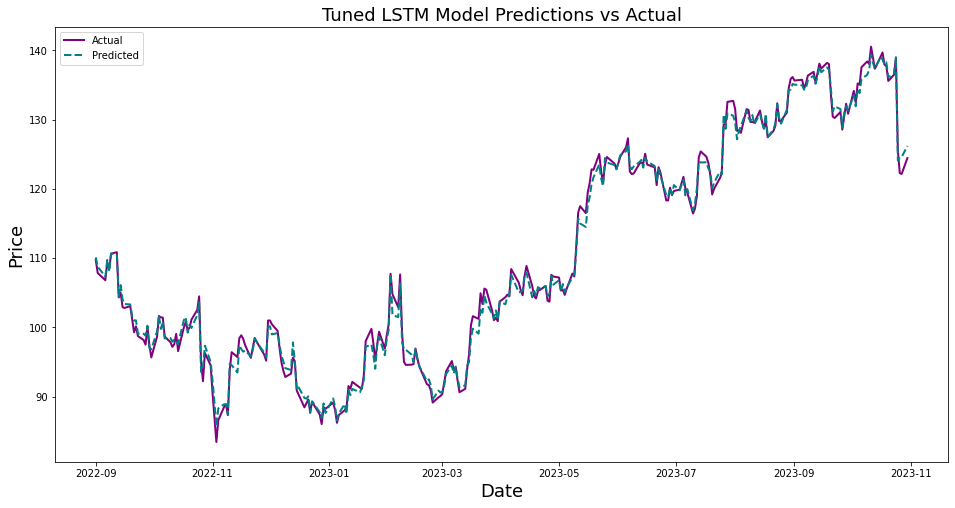

In [29]:
# Plot the actual vs predicted prices for LSTM model
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='purple', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_lstm_inv, linewidth=2, color='teal', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [30]:
# TCN model with hyperparameter tuning
# Define the parameter grid
param_grid = {'epochs': [100, 150, 200], 'batch_size': [64, 128] }

tcn_model = KerasRegressor(build_fn=create_tcn)

# Grid search on TCN
grid = GridSearchCV(estimator=tcn_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the grid search model
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for TCN from the grid search
best_tcn_model = grid_result.best_estimator_

# Predicting the test data
pred_best_tcn = best_tcn_model.predict(X_test)

# Inverse transform the predictions
pred_best_tcn_inv = target_scaler.inverse_transform(pred_best_tcn.reshape(-1,1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:  {'batch_size': 64, 'epochs': 150}
Best score:  -0.00015165729600994383
Best estimator:  <keras.wrappers.scikit_learn.KerasRegressor object at 0x000002C0F758AE50>
5/5 [==============================] - 0s 6ms/step


In [31]:
# Calculate the Evaluation Metrics for TCN model
best_tcn_mse = mean_squared_error(y_test_inv, pred_best_tcn_inv)
best_tcn_rmse = np.sqrt(best_tcn_mse)
best_tcn_mae = mean_absolute_error(y_test_inv, pred_best_tcn_inv)
best_tcn_r2 = r2_score(y_test_inv, pred_best_tcn_inv)

print("Tuned TCN Model Evaluation Metrics")
print("---------------------------------")
print("MSE: {:.4f}".format(best_tcn_mse))
print("RMSE: {:.4f}".format(best_tcn_rmse))
print("MAE: {:.4f}".format(best_tcn_mae))
print("R2: {:.4f}".format(best_tcn_r2))

Tuned TCN Model Evaluation Metrics
---------------------------------
MSE: 5.8930
RMSE: 2.4275
MAE: 2.1563
R2: 0.9774


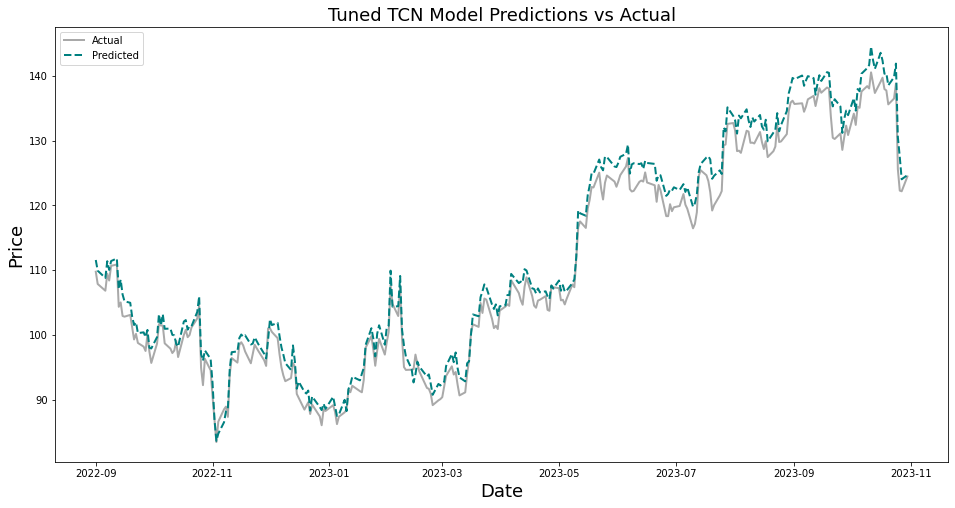

In [32]:
# Plot the actual vs predicted prices for TCN model
plt.figure(figsize=(16,8))
plt.title('Tuned TCN Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkgrey', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_tcn_inv, linewidth=2, color='teal', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [33]:
# Stacked LSTM-TCN model with hyperparameter tuning
stacked_tuned_pred = np.column_stack((pred_best_lstm, pred_best_tcn))

# Train final regressor based on stacked predictions
final_regressor_tuned = LinearRegression().fit(stacked_tuned_pred, y_test)

# Make predictions
final_pred_tuned = final_regressor_tuned.predict(stacked_tuned_pred)

# Invert predictions
final_pred_tuned_inv = target_scaler.inverse_transform(final_pred_tuned.reshape(-1,1))

In [34]:
# Calculate the Evaluation metrics for stacked model
final_mse_tuned = mean_squared_error(y_test_inv, final_pred_tuned_inv)
final_rmse_tuned = np.sqrt(final_mse_tuned)
final_mae_tuned = mean_absolute_error(y_test_inv, final_pred_tuned_inv)
final_r2_tuned = r2_score(y_test_inv, final_pred_tuned_inv)

print("Tuned LSTM-TCN Stacked Model Evaluation Metrics")
print("-----------------------------------------------")
print("MSE: {:.4f}".format(final_mse_tuned))
print("RMSE: {:.4f}".format(final_rmse_tuned))
print("MAE: {:.4f}".format(final_mae_tuned))
print("R2: {:.4f}".format(final_r2_tuned))

Tuned LSTM-TCN Stacked Model Evaluation Metrics
-----------------------------------------------
MSE: 0.7038
RMSE: 0.8389
MAE: 0.6735
R2: 0.9973


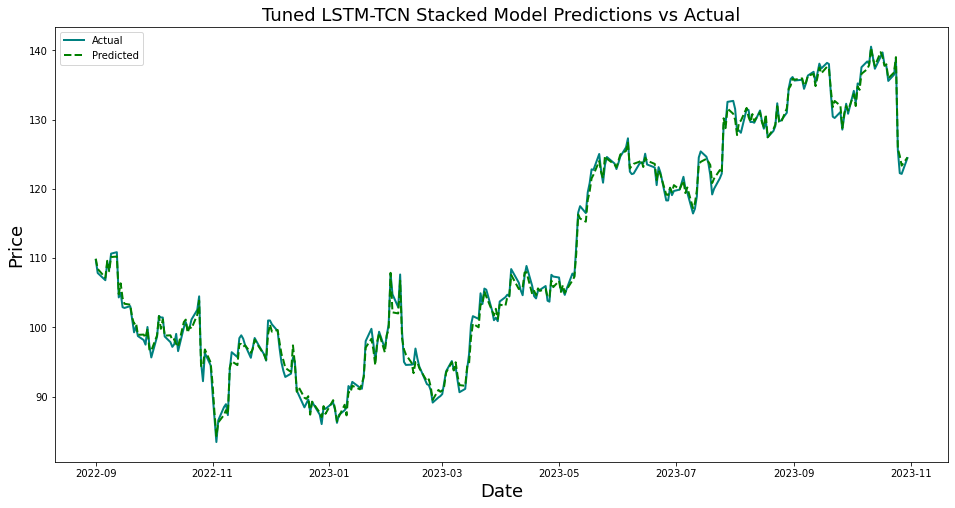

In [35]:
# Plot the actual vs predicted prices for stacked model
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM-TCN Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='teal', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_tuned_inv, linewidth=2, color='green', label='Predicted', linestyle='--')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [36]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = best_lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 19ms/step
Predicted Closing Prices for the Next 2 Days (Best LSTM Model):
Day 1:126.210
Day 2:123.149


In [37]:
last_features = X_scaled[-1:]

# Predict using the TCN model
predicted_prices_tcn = []

last_features_tcn = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_tcn = best_tcn_model.predict(last_features_tcn)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_tcn = predicted_price_tcn.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_tcn = target_scaler.inverse_transform(predicted_price_reshaped_tcn)[0][0]
    predicted_prices_tcn.append(inverse_transformed_price_tcn)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_tcn = np.array([
        last_features_tcn[0, 1], 
        last_features_tcn[0, 2], 
        predicted_price_reshaped_tcn[0, 0], 
        (predicted_price_reshaped_tcn[0, 0] - last_features_tcn[0, 3]) / last_features_tcn[0, 3],
        np.mean(np.append(last_features_tcn[0, 4:6], predicted_price_reshaped_tcn[0, 0])),
        np.mean(np.append(last_features_tcn[0, 5:], predicted_price_reshaped_tcn[0, 0])),
        np.std(np.append(last_features_tcn[0, 6:], predicted_price_reshaped_tcn[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_tcn = new_features_tcn

print("Predicted Closing Prices for the Next 2 Days (Best TCN Model):")
for i, price in enumerate(predicted_prices_tcn):
    print(f"Day {i+1}:" "{:.3f}".format(price))


1/1 [==============================] - 0s 21ms/step
Predicted Closing Prices for the Next 2 Days (Best TCN Model):
Day 1:124.673
Day 2:125.022


In [38]:
last_features = X_scaled[-1:]

# Predict using the Stacked LSTM-TCN model
predicted_prices_stacked = []

for day in range(2):
    # Reshape the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predict using LSTM & CNN models
    lstm_pred_for_stacking = best_lstm_model.predict(last_features_lstm).flatten()
    tcn_pred_for_stacking = best_tcn_model.predict(last_features).flatten()

    # Stacking LSTM and tcn predictions
    stacked_predictions = np.column_stack((lstm_pred_for_stacking, tcn_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # For the next prediction, update the features with the newly predicted price.
    # We reuse the logic from LSTM to compute new features for simplicity.
    new_features_stacked = np.array([
        last_features[0, 1], 
        last_features[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features[0, 3]) / last_features[0, 3],
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features_stacked

print("\nPredicted Closing Prices for the Next 2 Days (Best Stacked LSTM-TCN Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step

Predicted Closing Prices for the Next 2 Days (Best Stacked LSTM-TCN Model):
Day 1:125.708
Day 2:123.505


In [39]:
# Build a dataframe with actual and predicted prices for the best models
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'Tuned LSTM': pred_best_lstm_inv.flatten(), 'Tuned TCN': pred_best_tcn_inv.flatten(), 'Tuned LSTM-TCN': final_pred_tuned_inv.flatten()})
df_pred_1

,Date,Actual,Tuned LSTM,Tuned TCN,Tuned LSTM-TCN
0,2022-09-01,109.739998,110.123871,111.555023,109.915108
1,2022-09-02,107.849998,108.749352,109.901978,108.441772
2,2022-09-06,106.809998,107.343475,108.784935,107.175407
3,2022-09-07,109.449997,109.735909,111.371651,109.618004
4,2022-09-08,108.379997,108.065170,110.019966,108.102890
...,...,...,...,...,...
287,2023-10-24,138.809998,139.022888,141.898544,139.041748
288,2023-10-25,125.610001,124.118301,130.560791,125.827599
289,2023-10-26,122.279999,124.535561,127.494522,124.778854
290,2023-10-27,122.169998,124.606163,124.026840,123.365013
